# Hybrid A* 

## First Try

Imports

In [44]:
%pip install shapely

Note: you may need to restart the kernel to use updated packages.


In [45]:
import numpy as np
import heapq
import math
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

Helper Functions

In [46]:
XY_GRID_RESOLUTION = 0.35                # meters
THETA_GRID_RESOLUTION = np.deg2rad(10)  # 24 headings
DT = 0.2                                 # time step
VEHICLE_SPEED = 2.5                      # m/s
WHEELBASE = 2.5                          # meters
STEERING_ANGLES = [-0.6, -0.45, -0.3, -0.15, 0, +0.15, +0.3, +0.45, +0.6]
CAR_RADIUS = 1.0     # approximate half-width of the robot/car
SAFETY_MARGIN = 1.0  # how much extra distance you want

obstacle_safe_radius = CAR_RADIUS + SAFETY_MARGIN


# POLYGON CREATION USING SHAPELY
def create_track_polygon(track_bounds):
    # Ensure closed loop for safety
    if track_bounds[0] != track_bounds[-1]:
        track_bounds = track_bounds + [track_bounds[0]]
    return Polygon(track_bounds)

# OBSTACLE COLLISION CHECK
def is_near_obstacle(x, y, obstacles):
    OBSTACLE_SAFE_RADIUS = CAR_RADIUS + SAFETY_MARGIN
    if not obstacles:
        return False
    for ox, oy in obstacles:
        if np.hypot(ox - x, oy - y) < OBSTACLE_SAFE_RADIUS:
            return True
    return False


# STATE DISCRETIZATION
def state_key(x, y, theta):
    return (
        round(x / XY_GRID_RESOLUTION),
        round(y / XY_GRID_RESOLUTION),
        round(theta / THETA_GRID_RESOLUTION)
    )

# BICYCLE MODEL MOTION
def simulate_motion(x, y, theta, steer):
    x_new = x + VEHICLE_SPEED * math.cos(theta) * DT
    y_new = y + VEHICLE_SPEED * math.sin(theta) * DT
    theta_new = theta + (VEHICLE_SPEED / WHEELBASE) * math.tan(steer) * DT
    theta_new = (theta_new + 2 * math.pi) % (2 * math.pi)
    return x_new, y_new, theta_new


# NEIGHBOR GENERATION
def generate_neighbors(node):
    neighbors = []
    for steer in STEERING_ANGLES:
        nx, ny, ntheta = simulate_motion(node.x, node.y, node.theta, steer)
        neighbors.append((nx, ny, ntheta))
    return neighbors

# HEURISTIC (distance to goal)
def heuristic(x, y, goal):
    gx, gy = goal
    # return np.hypot(gx - x, gy - y)
    return 1.2*np.hypot(gx - x, gy - y) #weighting to favor goal direction

Hybrid A* Algorithm

In [47]:
class HybridNode:
    def __init__(self, x, y, theta, g, h, parent=None):
        self.x = x
        self.y = y
        self.theta = theta
        self.g = g
        self.h = h
        self.f = g + h
        self.parent = parent

    def __lt__(self, other):
        return self.f < other.f


def hybrid_astar(start, goal, track_bounds, obstacles=[]):

    # Create Shapely polygon
    track_poly = create_track_polygon(track_bounds)

    start_x, start_y = start
    goal_x, goal_y = goal

    start_node = HybridNode(
        x=start_x,
        y=start_y,
        theta=0.0,
        g=0.0,
        h=heuristic(start_x, start_y, goal),
        parent=None
    )

    open_list = []
    heapq.heappush(open_list, start_node)

    closed = set()  # discretized visited states

    while open_list:
        current = heapq.heappop(open_list)

        # Check if goal reached
        if np.hypot(current.x - goal_x, current.y - goal_y) < 2.0:
            path = []
            node = current
            while node:
                path.append((node.x, node.y, node.theta))
                node = node.parent
            return path[::-1]

        closed_key = state_key(current.x, current.y, current.theta)
        if closed_key in closed:
            continue
        closed.add(closed_key)

        # Expand neighbors
        for nx, ny, ntheta in generate_neighbors(current):

            # 1. Track boundary collision via Shapely
            if not track_poly.contains(Point(nx, ny)):
                continue

            # 2. Obstacle collision
            if obstacles and is_near_obstacle(nx, ny, obstacles):
                continue

            neighbor_key = state_key(nx, ny, ntheta)
            if neighbor_key in closed:
                continue

            g_new = current.g + 1
            h_new = heuristic(nx, ny, goal)

            new_node = HybridNode(
                x=nx,
                y=ny,
                theta=ntheta,
                g=g_new,
                h=h_new,
                parent=current
            )

            heapq.heappush(open_list, new_node)

    return []


In [48]:
def compute_velocities_from_path(raw_path):
    velocities = []
    for i in range(1, len(raw_path)):
        x1, y1, _ = raw_path[i - 1]
        x2, y2, _ = raw_path[i]
        dx = x2 - x1
        dy = y2 - y1
        velocity = np.hypot(dx, dy)
        velocities.append(velocity)
    return velocities

Visualization Function

In [49]:
def visualize_path(track_bounds, car_location, goal, path, obstacles=None, title=""):
    plt.figure(figsize=(8, 6))
    plt.title(title)

    # Draw track boundaries
    tb = close_polygon(track_bounds)
    bx, by = zip(*tb)
    plt.plot(bx, by, 'b-', linewidth=2, label="Track Boundary")

    # Draw Start & Goal
    plt.plot(car_location[0], car_location[1], 'go', markersize=8, label="Start")
    plt.plot(goal[0], goal[1], 'ro', markersize=8, label="Goal")

    # Draw Obstacles
    if obstacles and len(obstacles) > 0:
        ox = [o[0] for o in obstacles]
        oy = [o[1] for o in obstacles]
        plt.scatter(ox, oy, c='red', s=30, label="Obstacles", alpha=0.7)

    # Draw Path
    if path and len(path) > 1:
        px = [p[0] for p in path]
        py = [p[1] for p in path]
        plt.plot(px, py, 'yellow', linewidth=2, label="Hybrid A* Path")
    else:
        plt.text(0.5, 0.5, "NO PATH FOUND", fontsize=16, color="red", transform=plt.gca().transAxes)

    plt.legend()
    plt.axis("equal")
    plt.grid(True)
    plt.show()


Test Cases

In [50]:
import numpy as np

test_cases = [

    # 1. Simple Rectangle (baseline sanity check)
    {
        "name": "Simple Rectangle",
        "track_bounds": [(0,0), (100,0), (100,60), (0,60)],
        "car_location": (10,10),
        "goal": (90,50),
        "obstacles": []
    },

    # 2. L-Shape Track
    {
        "name": "L-Shape Track",
        "track_bounds": [(0,0), (80,0), (80,20), (30,20), (30,60), (0,60)],
        "car_location": (5,5),
        "goal": (70,15),
        "obstacles": []
    },

    # 3. Narrow Corridor (tests turning radius / corridor navigation)
    {
        "name": "Narrow Corridor",
        "track_bounds": [(0,0), (100,0), (100,20), (0,20)],
        "car_location": (10,10),
        "goal": (90,10),
        "obstacles": []
    },

    # 4. Complex Multi-Turn Polygon Track (wider “road” but irregular shape)
    {
        "name": "Complex Polygon Track",
        "track_bounds": [(10,10), (90,10), (100,40), (80,80),
                         (50,90), (20,70), (5,50)],
        "car_location": (20,20),
        "goal": (85,30),
        "obstacles": []
    },

    # 5. Obstacle-Heavy Field inside Rectangular Bounds (dense random obstacles)
    {
        "name": "Dense Random Obstacle Field",
        "track_bounds": [(0,0), (150,0), (150,150), (0,150)],
        "car_location": (20,20),
        "goal": (130,130),
        "obstacles": [
            (75 + np.random.randn()*18, 75 + np.random.randn()*18)
            for _ in range(120)
        ]
    },

    # 6. Bottleneck + Mixed-width Track With Random Obstacles near Bottleneck
    {
        "name": "Bottleneck with Obstacles",
        "track_bounds": [
            (0,0), (120,0), (120,40), (80,40),
            (80,20), (40,20), (40,40), (0,40)
        ],
        "car_location": (10,10),
        "goal": (110,30),
        "obstacles": [
            # cluster near the bottleneck to force planning around it
            (60 + np.random.randn()*3, 18 + np.random.randn()*2)
            for _ in range(15)
        ]
    },

    # 7. Sinusoidal / Curvy “Road” with Chicanes + Obstacles
    {
        "name": "Wavy Chicane Road",
        # track defined as a wide bounding polygon approximating a road
        "track_bounds": [
            (0,0), (120,0), (120,20),
            (100,40), (120,60), (120,80),
            (0,80), (0,60), (20,40), (0,20)
        ],
        "car_location": (5,5),
        "goal": (115,75),
        "obstacles": [
            # place obstacles (like cones/barrels) at various strategic locations
            (30 + np.random.randn()*2, 25 + np.random.randn()*2),
            (60 + np.random.randn()*2, 35 + np.random.randn()*2),
            (90 + np.random.randn()*2, 55 + np.random.randn()*2),
            (50 + np.random.randn()*2, 70 + np.random.randn()*2),
            (20 + np.random.randn()*2, 50 + np.random.randn()*2),
        ]
    },

    # 8. Maze-like Track (multiple dead-ends, narrow corridors)
    {
        "name": "Maze Track",
        "track_bounds": [
            (0,0), (140,0), (140,140), (100,140), (100,100),
            (120,100), (120,40), (20,40), (20,100), (40,100),
            (40,140), (0,140)
        ],
        "car_location": (10,10),
        "goal": (130,130),
        "obstacles": []
    },

    # 9. Typical Autonomous-Competition Track: Lane-like Boundaries + Random Cones/Barrels
    {
        "name": "Competition-Style Lane Track",
        # imagine a winding track within these bounds
        "track_bounds": [
            (0,0), (200,0), (200,120), (180,140),
            (160,120), (140,140), (120,120), (100,140),
            (80,120), (60,140), (40,120), (0,120)
        ],
        "car_location": (10,10),
        "goal": (180,110),
        "obstacles": [
            # random obstacles like barrels/cones — spacing ensures a minimum clearance around them
            (50, 60), (70, 70), (100, 80), (120, 90),
            (130, 100), (160, 110), (90, 50), (110, 30),
            (60, 20), (140, 40)
        ]
    },

    # 10. Track with “Choke + Wide → Narrow → Wide” Segments + Sparse Obstacles
    {
        "name": "Variable-width Track with Sparse Obstacles",
        "track_bounds": [
            (0,0), (250,0), (250,150), (200,150),
            (200,100), (150,100), (150,150), (0,150)
        ],
        "car_location": (10,10),
        "goal": (240,140),
        "obstacles": [
            (50 + np.random.randn()*5, 20 + np.random.randn()*5),
            (120 + np.random.randn()*5, 80 + np.random.randn()*5),
            (180 + np.random.randn()*5, 130 + np.random.randn()*5),
        ]
    }
]


In [51]:
def close_polygon(track_bounds):
    if track_bounds[0] != track_bounds[-1]:
        track_bounds.append(track_bounds[0])
    return track_bounds

Testing


--- Running Test Case: Simple Rectangle ---
Path found: Yes
Path length (number of waypoints): 177
Pose array length: 176
First 3 poses: [np.float64(0.5), np.float64(0.4999999999999998), np.float64(0.5000000000000007)]


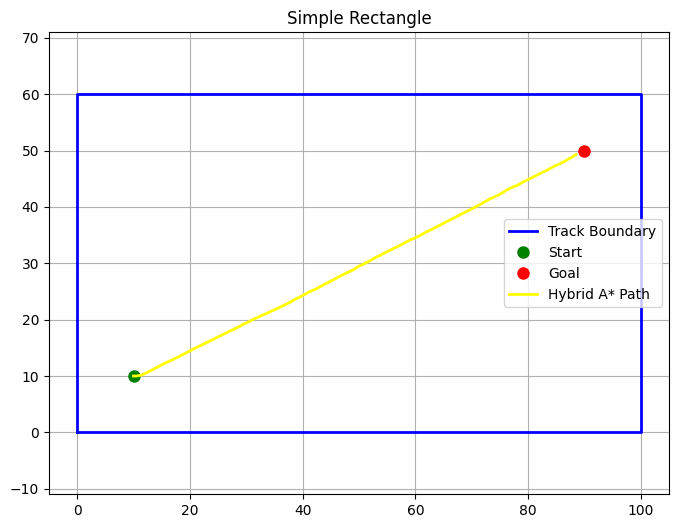


--- Running Test Case: L-Shape Track ---
Path found: Yes
Path length (number of waypoints): 129
Pose array length: 128
First 3 poses: [np.float64(0.5), np.float64(0.4999999999999999), np.float64(0.4999999999999997)]


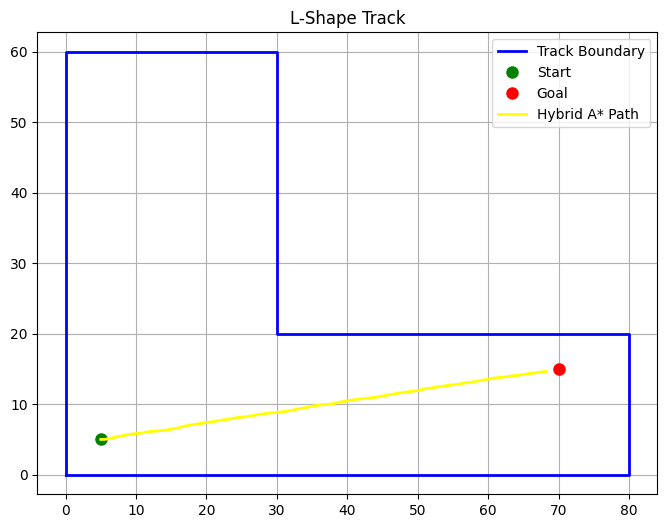


--- Running Test Case: Narrow Corridor ---
Path found: Yes
Path length (number of waypoints): 158
Pose array length: 157
First 3 poses: [np.float64(0.5), np.float64(0.49999999999999956), np.float64(0.5000000000000008)]


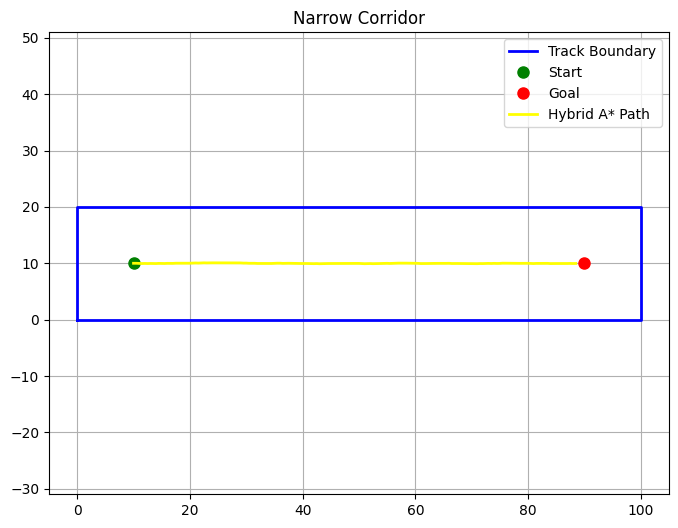


--- Running Test Case: Complex Polygon Track ---
Path found: Yes
Path length (number of waypoints): 129
Pose array length: 128
First 3 poses: [np.float64(0.5), np.float64(0.4999999999999998), np.float64(0.4999999999999995)]


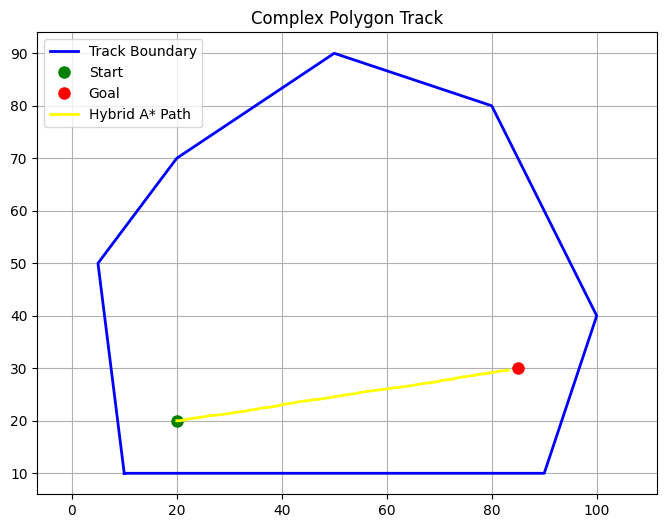


--- Running Test Case: Dense Random Obstacle Field ---


In [ ]:
results = []

for case in test_cases:
    print(f"\n--- Running Test Case: {case['name']} ---")

    track = case["track_bounds"]
    car = case["car_location"]
    goal = case["goal"]
    obstacles = case["obstacles"]

    # Run Hybrid A*
    raw_path = hybrid_astar(car, goal, track, obstacles)
    # Convert raw Hybrid A* path to array of poses
    pose_array = compute_velocities_from_path(raw_path)


    # Store results
    results.append({
        "name": case["name"],
        "pose_array": pose_array,
        "path_length": len(raw_path),
        "success": len(raw_path) > 0
    })

    print(f"Path found: {'Yes' if len(raw_path) > 0 else 'No'}")
    print(f"Path length (number of waypoints): {len(raw_path)}")    
    print(f"Pose array length: {len(pose_array)}")  
    print(f"First 3 poses: {pose_array[:3]}")


    # Visualize
    visualize_path(
        track_bounds=track,
        car_location=car,
        goal=goal,
        path=raw_path,
        obstacles=obstacles,
        title=case["name"]
    )

print("\nAll test cases finished.\n")

# Show summary
import pandas as pd

df_results = pd.DataFrame(results)
df_results


In [ ]:
from scipy.interpolate import CubicSpline

def smooth_path(raw_path):
    if len(raw_path) < 3:
        return raw_path

    x = [p[0] for p in raw_path]
    y = [p[1] for p in raw_path]
    theta = [p[2] for p in raw_path]

    # Generate cubic splines for x and y
    t = range(len(raw_path))
    spline_x = CubicSpline(t, x)
    spline_y = CubicSpline(t, y)

    # Smooth path
    smoothed_path = []
    for i in np.linspace(0, len(raw_path) - 1, num=100):
        smoothed_path.append((spline_x(i), spline_y(i), theta[int(i)]))

    return smoothed_path